# Bank Customer Segmentation with Affinity Propagation and Credit Risk Analysis  with Random Forest Classifier


## Introduction


###  Problem Statement:
Customer segmentation strategy and credit risk analysis in banking enable banks to improve customer targeting, enhance risk management, deliver personalized experiences, and make informed decisions.  This project seeks to improve understanding of customer behavior and creditworthiness, enabling more personalized marketing campaigns, targeted product offerings, and better risk management.

## Data

The German Credit datasetis a widely used dataset for credit risk assessment and classification tasks. It  consists of a collection of credit applications from German individuals seeking loans. The dataset was initially compiled by Prof. Dr. Hans Hofmann at the University of Hamburg. It contains a total of 1000  samples with each sample representing an individual credit application.

Furthermore, the German Credit dataset typically includes a target variable, which indicates whether an applicant is considered a good credit risk (e.g., "good") or a bad credit risk (e.g., "bad"). This variable is often used for classification tasks, where the goal is to predict the creditworthiness of future loan applicants based on their characteristics.

The German Credit dataset can be used for customer segmentation, which is the process of dividing a customer base into distinct groups based on common characteristics or behaviors. Customer segmentation helps businesses gain a better understanding of their customers and tailor their marketing strategies and services accordingly. 

The dataset contains a mix of both categorical and numerical attributes that provide information about the applicants. Some common attributes found in the German Credit dataset may include:

* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (numeric, in DM - Deutsch Mark)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
* Risk (good, bad)

## Library Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import AffinityPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, roc_curve, auc

from scipy.stats import uniform
from scipy import interp

import warnings
warnings.filterwarnings("ignore")

## Part 1 - Data Cleaning

In [2]:
df_accounts = pd.read_csv('german_credit_data.csv')

In [3]:
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


5 of our columns seems to be categorical in nature. It also looks like we have some NaNs at Savings Account and Credit Amount columns. There's also an Unnamed column which I think is another index column that we could get rid of. We'll just do a quick head check to verify.

In [4]:
df_accounts.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


The Unnamed column was indeed an index column and we can get rid of it.

In [5]:
df_accounts = df_accounts.drop(columns=['Unnamed: 0'])
df_accounts

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


Checking the unique values in each categorical column.

In [6]:
categorical_columns = df_accounts.select_dtypes(include=['object']).columns

for column in categorical_columns:
    unique_values = df_accounts[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print()    

Unique values in column 'Sex':
['male' 'female']

Unique values in column 'Housing':
['own' 'free' 'rent']

Unique values in column 'Saving accounts':
[nan 'little' 'quite rich' 'rich' 'moderate']

Unique values in column 'Checking account':
['little' 'moderate' nan 'rich']

Unique values in column 'Purpose':
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']

Unique values in column 'Risk':
['good' 'bad']



Now we'll check how many NaNs we have for the Savings Accounts and Checking Account.

There's quite a lot of missing Checking account and if we are to drop all of them we'll be left with 60% of our original data. I bet some of the customers only had either Savings or Checking and not both.

In [7]:
df_accounts.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [8]:
df_accounts = df_accounts.fillna('None')
df_accounts.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

## Part 2 - Exploratory Data Analysis

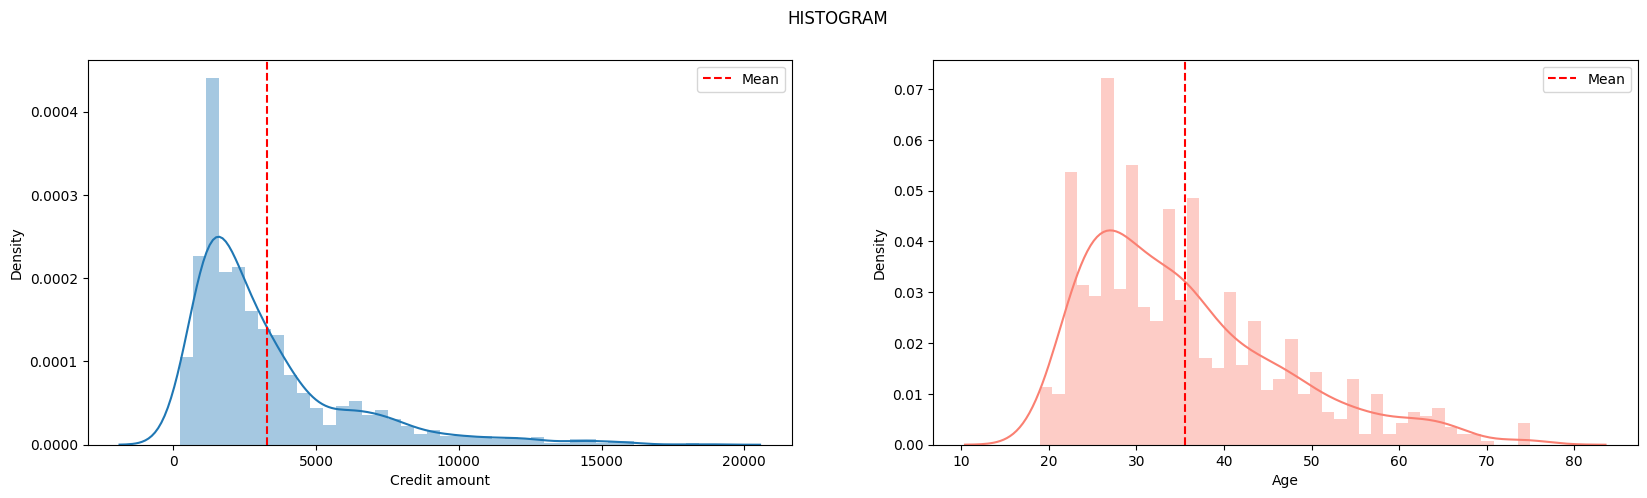

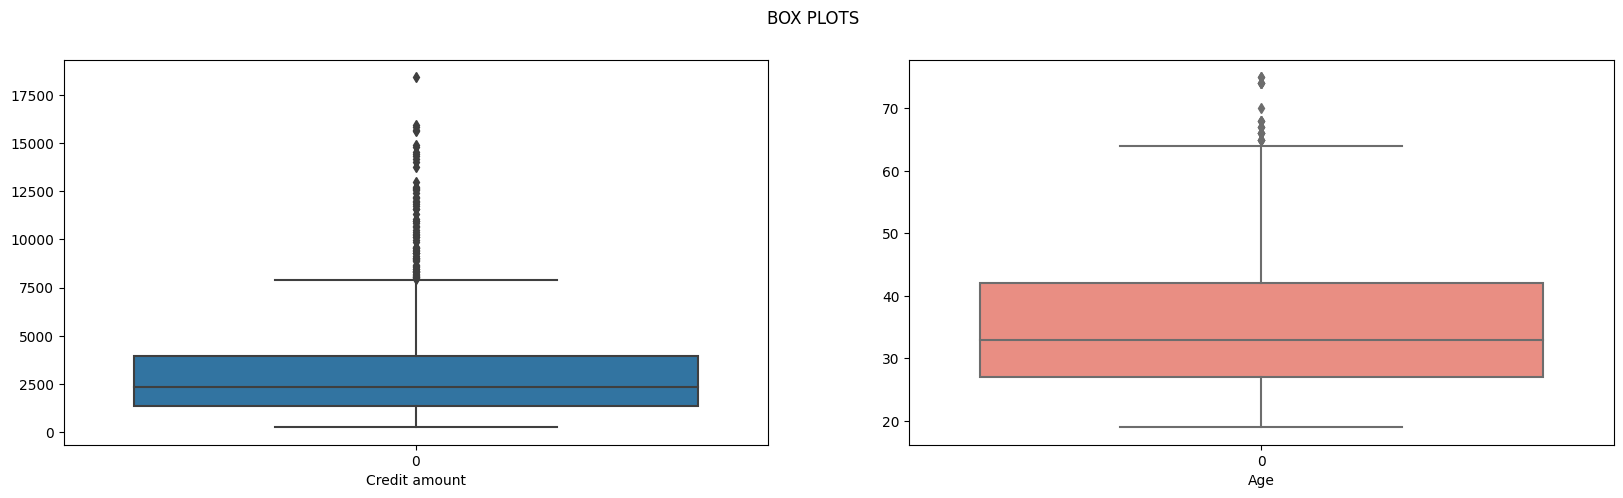

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plt.suptitle('HISTOGRAM')
sns.distplot(df_accounts['Credit amount'], bins=40, ax=ax[0]);
sns.distplot(df_accounts['Age'], bins=40, ax=ax[1], color='salmon');

# Add mean lines
mean_credit_amount = np.mean(df_accounts['Credit amount'])
mean_age = np.mean(df_accounts['Age'])

ax[0].axvline(x=mean_credit_amount, color='red', linestyle='--', label='Mean')
ax[1].axvline(x=mean_age, color='red', linestyle='--', label='Mean')

# Add legend
ax[0].legend()
ax[1].legend()

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('BOX PLOTS')
sns.boxplot(df_accounts['Credit amount'], ax=ax[0])
ax[0].set_xlabel('Credit amount')
sns.boxplot(df_accounts['Age'], ax=ax[1], color='salmon')
ax[1].set_xlabel('Age')

plt.show()

In [10]:
df_accounts[['Age', 'Credit amount']].describe()

,Age,Credit amount
count,1000.000000,1000.000000
mean,35.546000,3271.258000
std,11.375469,2822.736876
min,19.000000,250.000000
25%,27.000000,1365.500000
50%,33.000000,2319.500000
75%,42.000000,3972.250000
max,75.000000,18424.000000


#### Insights
---
* Credit account amount are around 2000 - 3000
* The Credit Amount is positively skewed,  there is a long tail on the right side of the distribution, indicating the presence of a few extremely large credit amounts.
* The majority of the data points are concentrated towards the lower end of the distribution.
The tail of the distribution extends towards the higher values, indicating the presence of outliers or extreme values.
* Positive skewness suggests that there are relatively fewer instances of large credit amounts, but those instances have a significant impact on the overall distribution. This could imply that there are a few borrowers or transactions with exceptionally high credit amounts, while the majority of borrowers or transactions have smaller credit amounts.
* The mean is typically larger than the median. The mean is pulled towards the higher values by the presence of the long tail on the right.


### Multivariate analysis by sex:

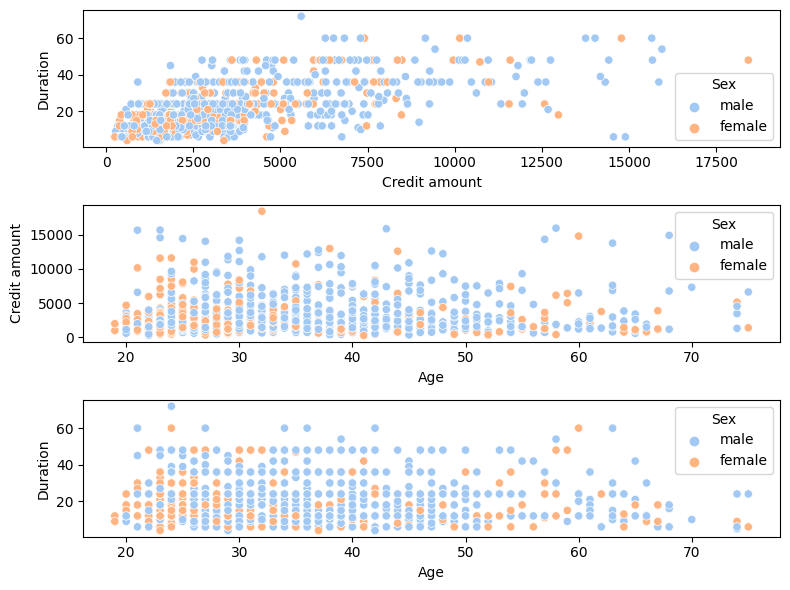

In [11]:
def multiscatter(df_accounts, h=None, pal="pastel"):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,6))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=df_accounts, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=df_accounts, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=df_accounts, ax=ax3)
    plt.tight_layout()

multiscatter(df_accounts, h="Sex")

#### Insights
---
* From the data we see that women are usually younger than men.
* The first plot indicates that there is no distinct disparity between men and women regarding the credit amount and duration.
* By visual examination, there appears to be a positive correlation between the duration and amount of credit, which is reasonable.

### Savings Accounts

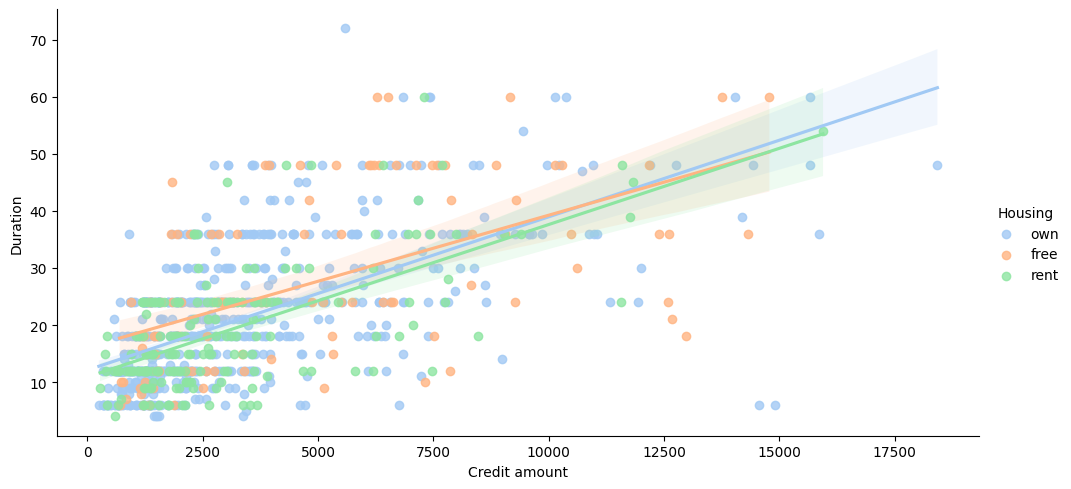

In [12]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=df_accounts, palette="pastel", aspect=2)

#### Insights
---
The plot above reveals that there is no noticeable distinction between the different housing categories.

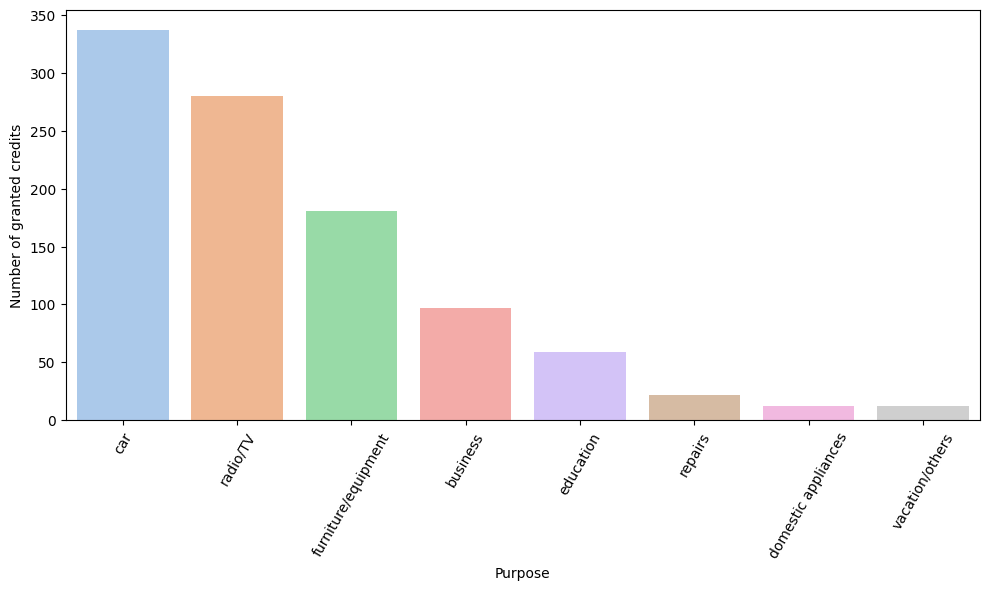

In [42]:
n_credits = df_accounts.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits, palette = 'pastel')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

Most of credits were granted for car and radio/TV.

In [35]:
# Defining a function for plotting multiple boxplots

def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=df_accounts, palette = 'pastel')
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

### Purpose, Credit Amount, and Sex

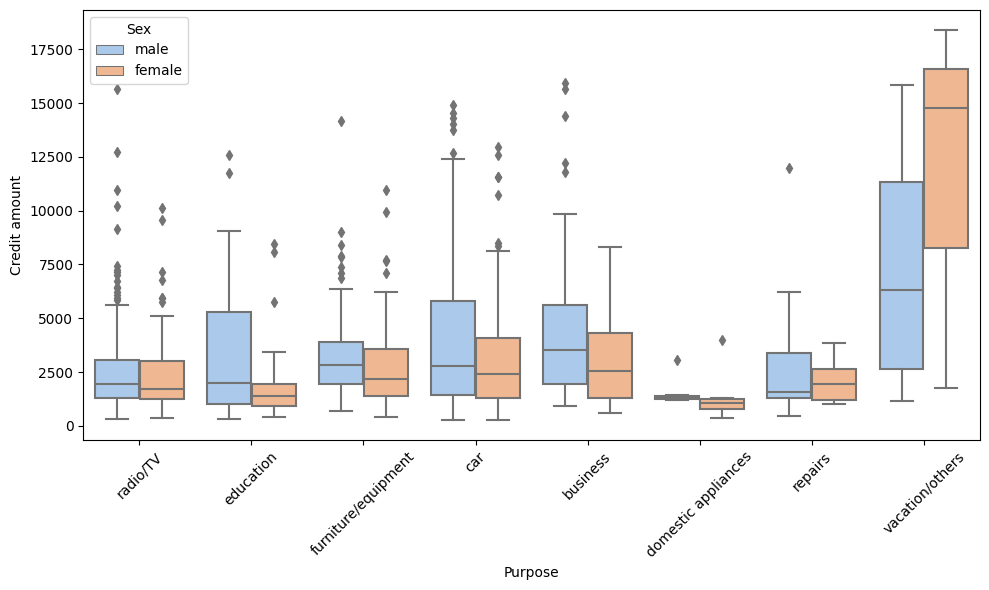

In [36]:
boxes("Purpose","Credit amount","Sex")

#### Insights
---
The provided plot reveals several insights regarding credit amounts and categories. Notably, the largest credit amounts are primarily associated with the "vacations/others" category, while the smallest amounts are related to domestic appliances. It is important to note that there are outliers on the upper end of the box plots, indicating some instances of significantly higher credit amounts.

When examining the gender differences across categories, the plot suggests that, in general, there is no substantial disparity between men and women, except for the "vacations/others" category. However, it is important to consider that the number of credits granted in this particular category is relatively low, which might limit the conclusiveness of any observations.

### Purpose, Duration, and Sex

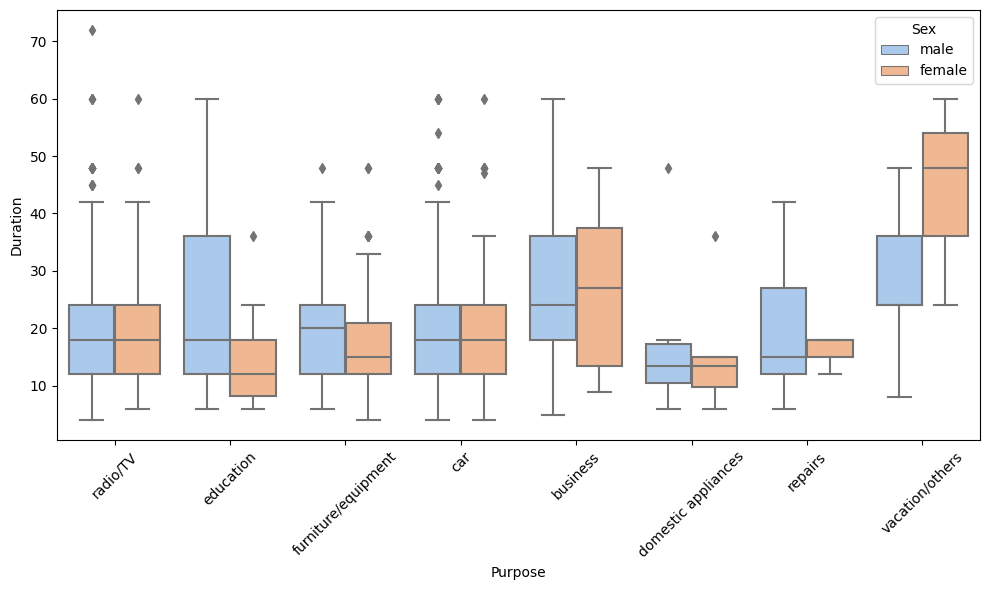

In [37]:
boxes("Purpose","Duration","Sex")

#### Insights
---
The presented boxplot suggests that, in general, there is no noticeable disparity in credit duration between men and women. Additionally, no clear trend emerges when comparing credit duration across different categories. However, an observation can be made that the shortest credit durations are associated with the category of domestic appliances. This finding aligns with the insights gained from the previous graph depicting credit amounts, where the domestic appliances category exhibited the lowest credit amounts.


### Housing, Credit Amount, and Sex

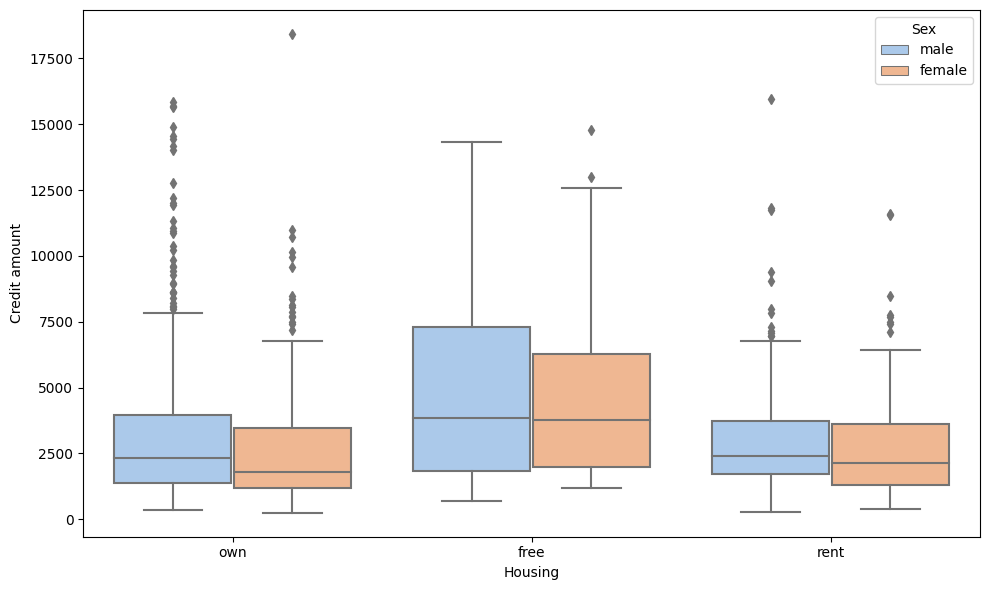

In [39]:
boxes("Housing","Credit amount","Sex",r=0)


#### Insights
---
When examining the housing category, the analysis reveals that there is generally no significant difference in credit amounts, regardless of the type of housing individuals have. However, there is a slight trend observed where individuals with "free" housing tend to take slightly larger credit amounts compared to other housing categories.

This finding suggests that the availability of "free" housing, which may indicate that individuals have lower housing expenses, could potentially lead them to borrow larger credit amounts. It is important to note that while there is a discernible trend, the difference in credit amounts between housing categories is not substantial.

### Job, Credit Amount, Duration, and Sex

In [49]:
def boxes(x, y, h, r=45):
    fig, ax = plt.subplots(figsize=(10, 6))
    box = sns.boxplot(x=x, y=y, hue=h, data=df_accounts, palette='pastel')
    box.set_xticklabels(['Unskilled and Non-Resident', 'Unskilled and Resident', 'Skilled', 'Highly Skilled'], rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

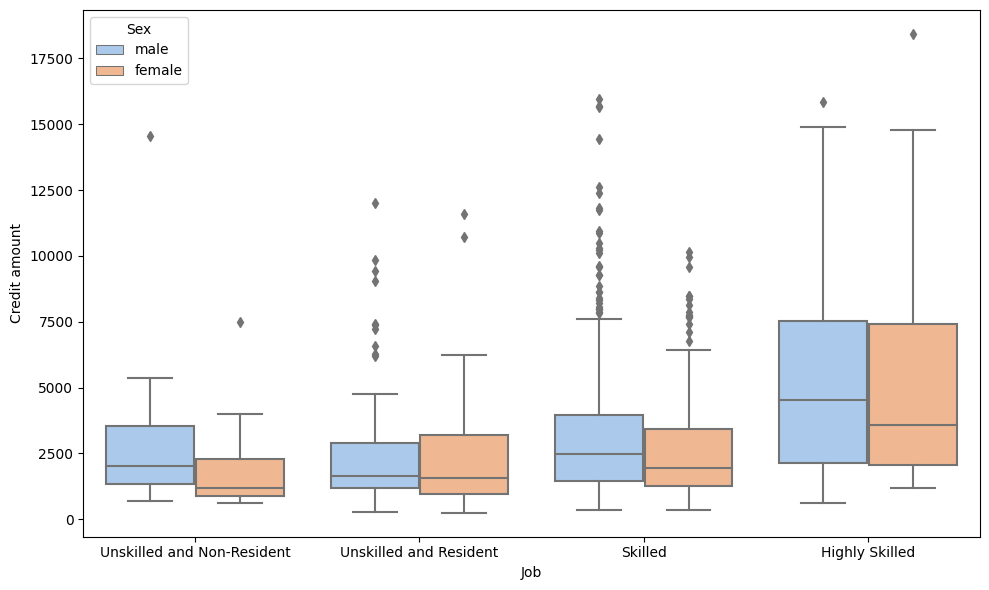

In [50]:
boxes("Job","Credit amount","Sex",r=0)

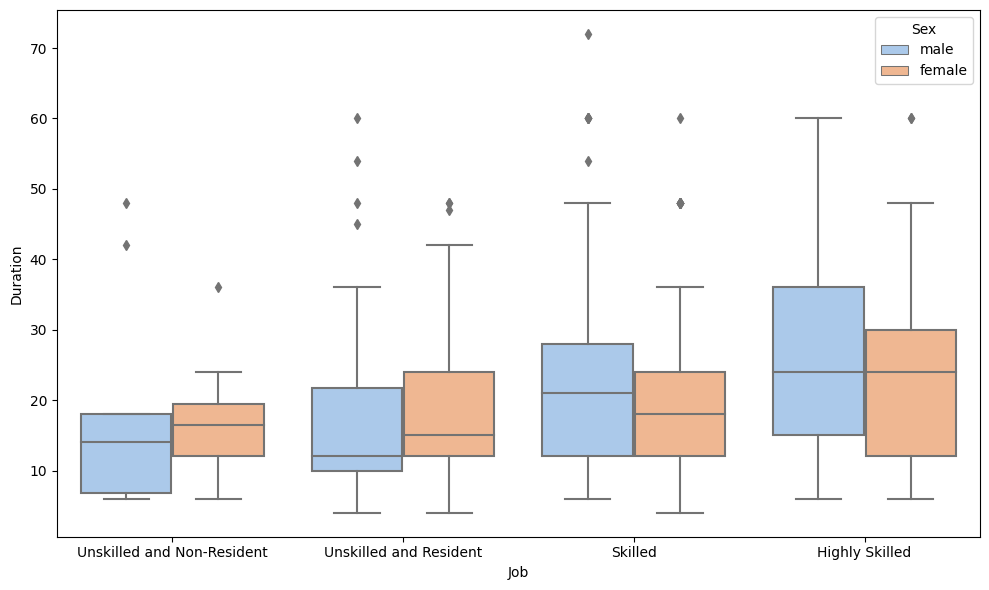

In [51]:
boxes("Job","Duration","Sex",r=0)


#### Insights
---
When considering the job category, the analysis indicates that there is generally no notable difference in credit amounts between men and women. However, there is an interesting trend observed in relation to Highly Skilled workers, where individuals in this category tend to borrow larger credit amounts for longer durations.

This finding suggests that Highly Skilled workers is associated with a higher borrowing capacity or financial need that necessitates larger credit amounts over an extended period. It is important to note that despite this trend, there are no significant differences between men and women in terms of credit amounts across the various job categories.

This analysis provides insights into the relationship between job category, credit amounts, and duration. While there is no discernible gender disparity, the observation of job category 3 exhibiting higher credit amounts and longer durations highlights the influence of occupation or profession on borrowing behavior.

## Part 3 - Clustering

Based from our earlier observatiobns, for our clustering we will create a subset containing the following variables:
1. Age
2. Credit amount
3. Duration.

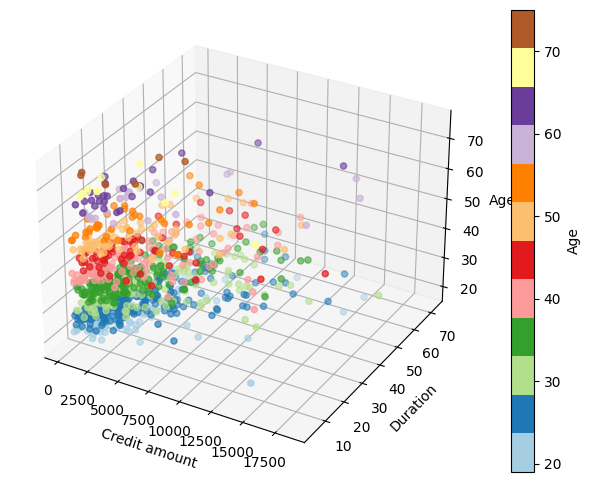

In [61]:
# Define the color palette
palette = "Paired"

# Create the figure and subplot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with pastel color palette
scatter = ax.scatter(df_accounts["Credit amount"], df_accounts["Duration"], df_accounts["Age"], c=df_accounts["Age"], cmap=palette)

# Set labels for x, y, and z axes
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

# Add a colorbar
cbar = fig.colorbar(scatter)
cbar.set_label("Age")

# Show the plot
plt.show()

In [23]:
#Selecting columns for clusterisation
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = df_accounts.loc[:,selected_cols]

In [26]:
# Defining a function to plot 3 histograms in one

def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

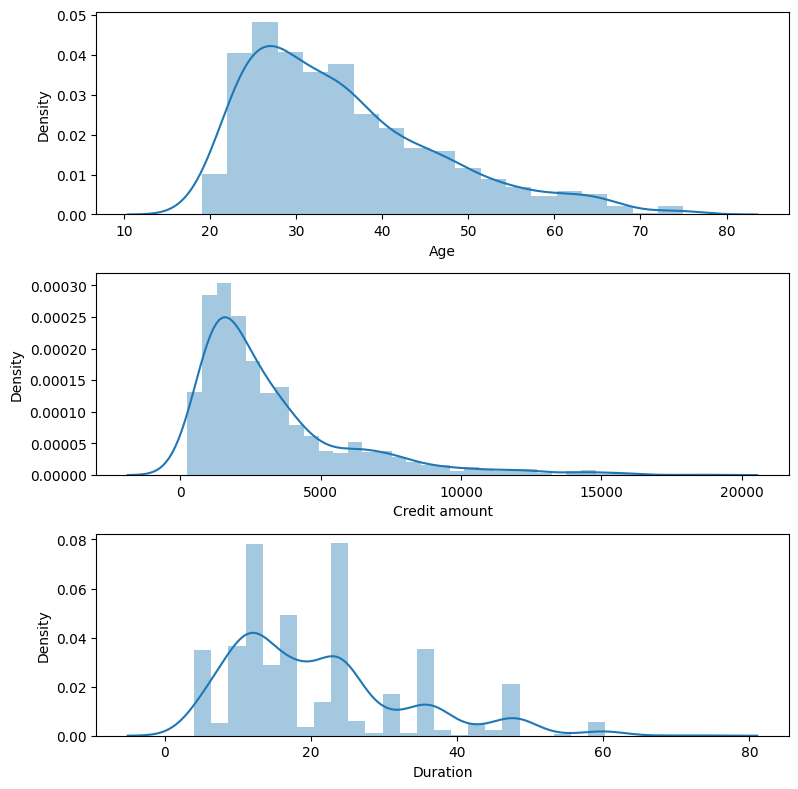

In [27]:
distributions(cluster_data)

### Dealing with Skewness
---
As we already know that we have a skewed data, a dataset with skewness indicates that the data is not evenly distributed around the mean. It can have a significant impact on data analysis and modeling as it can violate the assumptions of certain statistical methods.

When dealing with skewed data, transforming the data using a logarithmic function is a common approach to reduce skewness. The logarithmic transformation is useful because it compresses the range of larger values while expanding the range of smaller values, which can help normalize the distribution.

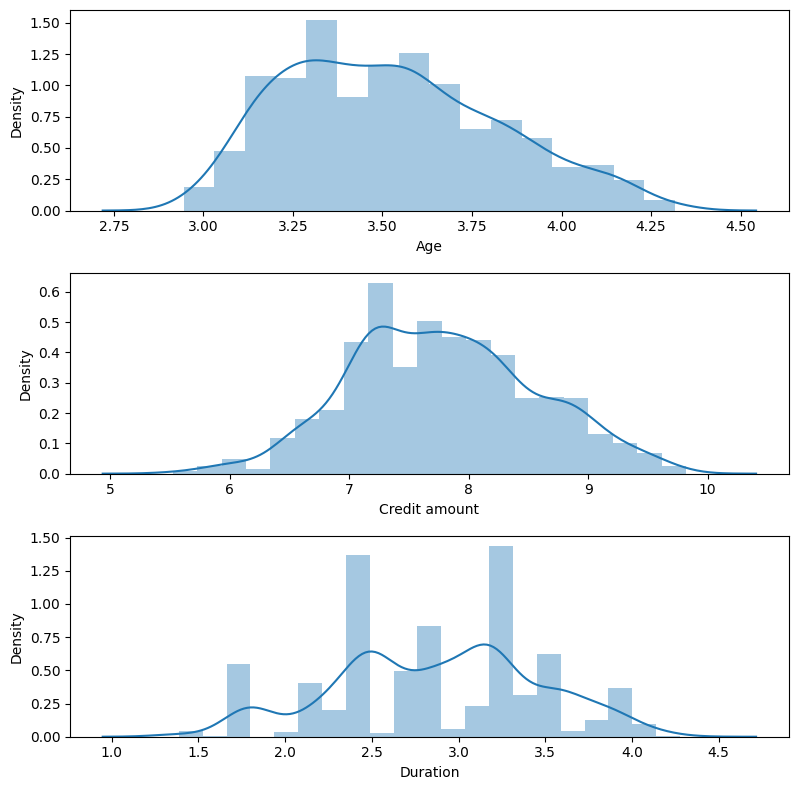

In [28]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

In [29]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

## Clustering with Affinity Propagation

**Affinity Propagation** is a clustering algorithm that **does not require the upfront specification of the number of clusters**. Instead, the algorithm determines the number of clusters based on the data and its internal similarity structure. The algorithm achieves this by iteratively propagating "affinities" between data points to identify exemplar points, which act as representatives of clusters.

There are two key parameters in Affinity Propagation: 

1. Preference - determines the degree to which each data point considers itself an exemplar. Higher values of preference encourage more data points to become exemplars, resulting in more clusters. Conversely, lower values of preference lead to fewer exemplars and fewer clusters.

2. Damping - controls the amount of influence that each iteration has on the final clustering result. It prevents the algorithm from oscillating between different clustering configurations by damping the update steps. A higher damping value slows down the convergence rate, while a lower damping value speeds it up.

To determine the appropriate number of clusters using Affinity Propagation, you can fix the damping parameter and vary the preference parameter. By systematically adjusting the preference parameter and evaluating the resulting clustering solutions, you can observe the effect on the number of clusters obtained. This process allows you to explore different clustering configurations and select the one that best suits your data and analysis goals.

Typically, you would start with a range of preference values and assess the resulting number of clusters using evaluation metrics or visual inspection. You can then refine the range based on the initial results and continue the process until you find the desired number of clusters or identify a preferred clustering solution based on other criteria.

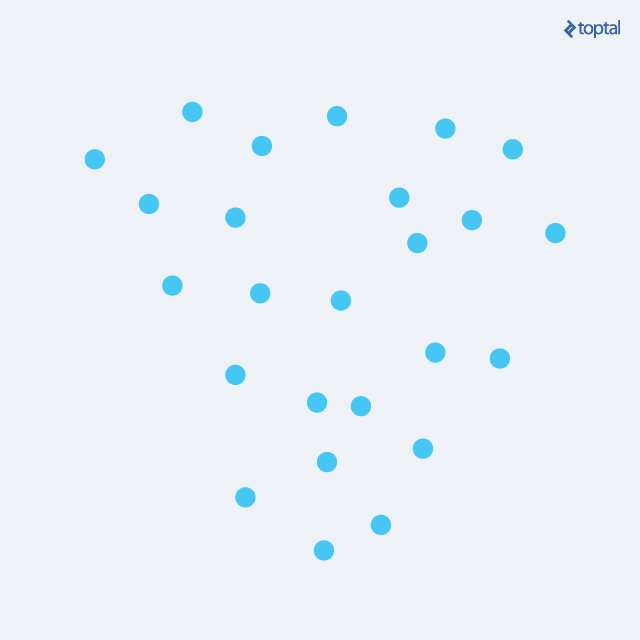



In summary, in Affinity Propagation, the algorithm dynamically determines the number of clusters based on the data's internal similarity structure. By fixing the damping parameter and varying the preference parameter, you can explore different clustering configurations and find the optimal number of clusters for your specific context.

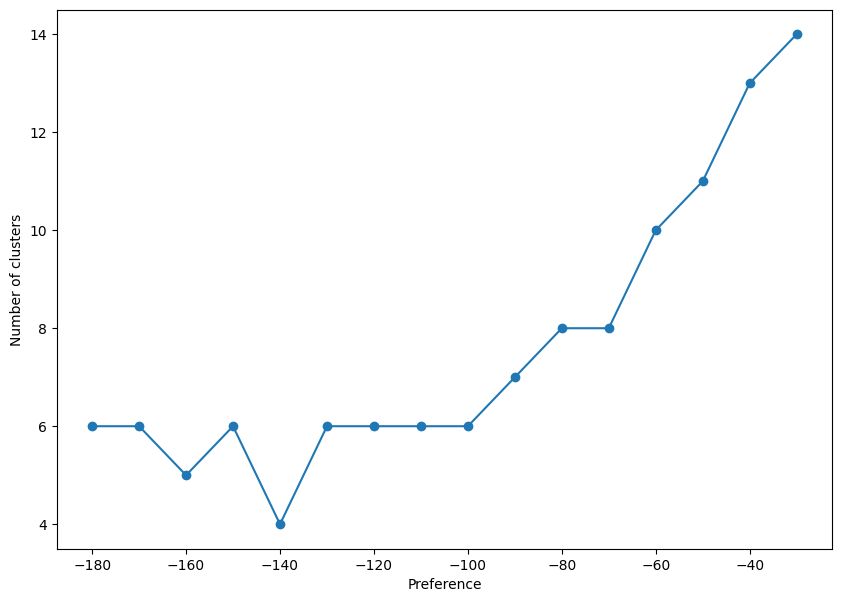

In [30]:
preferences = np.arange(-30,-190,-10)
clusters = []


for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')

As the value of the preference parameter decreases, the number of clusters tends to decrease as well. A lower preference value means that fewer data points will consider themselves as exemplars, resulting in fewer clusters being formed.

As the preference parameter approaches very small values, the algorithm becomes more selective in choosing exemplars, leading to a more consolidated clustering solution.

We'll explore the option of having four clusters by setting the preference parameter accordingly and observing the resulting clustering configuration. By fixing the preference parameter to a specific value, such as a value that tends to produce four clusters, you can run the Affinity Propagation algorithm and examine the clustering outcome.

By setting the preference parameter appropriately, such as decreasing its value to explore the option of four clusters, we can use Affinity Propagation to generate a clustering solution that aligns with your specific requirements and the underlying structure of your data.

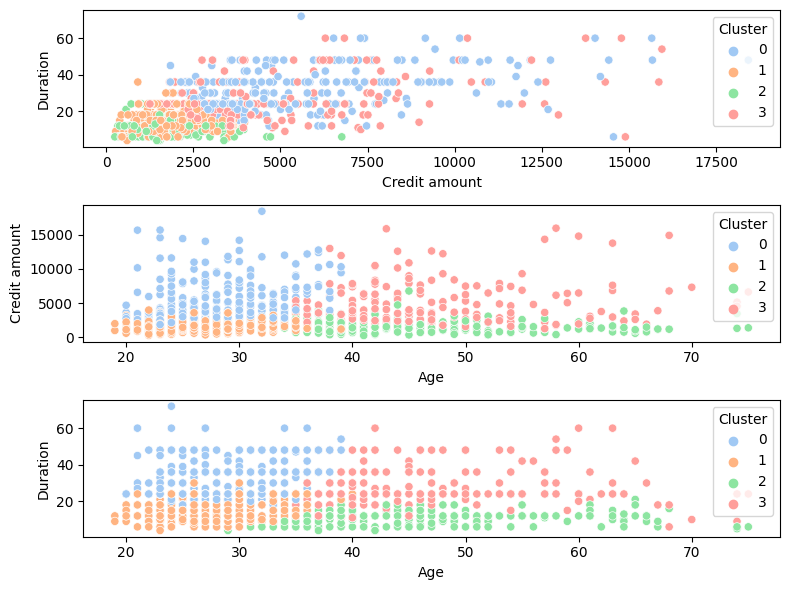

In [63]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data = cluster_data.assign(Cluster=labels_af)
multiscatter(clustered_data,'Cluster')

grouped_af = clustered_data.groupby(['Cluster']).mean().round(1)

In [64]:
customer_segments = clustered_data.groupby(['Cluster']).mean().round(1)
customer_segments

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


## Customer Segments

---

Cluster 0: "Affluent Young Professionals"

> This cluster represents young customers who tend to borrow larger amounts of credit for longer durations.
They are likely to be well-established professionals with higher income and financial stability.
They may have ambitious goals or investments that require substantial funding.

Cluster 1: "Early Career Starters"

> This cluster consists of younger customers who borrow smaller amounts of credit for shorter durations.
They are likely to be early in their careers or just starting out in the workforce.
They may be more cautious with their borrowing and prefer shorter-term financial commitments.

Cluster 2: "Frugal Seniors"


>  This cluster comprises older customers who borrow smaller amounts of credit for shorter durations.
They are likely to be retirees or individuals who prioritize financial prudence and avoiding excessive debt.
They may have a conservative approach to borrowing and prefer shorter repayment periods.


Cluster 3: "Established Professionals"


> Customers in this cluster borrow larger amounts of credit for moderate-term durations.
They are likely to be older, established professionals who have reached a certain level of financial stability.
They may have a balanced approach to borrowing, seeking reasonable credit amounts for manageable durations.



## Adding our generated Clusters/Customer Segments to the original Dataset


In [66]:
df_accounts.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,None,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,None,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [65]:
clustered_data.head()

,Age,Credit amount,Duration,Cluster
0,67,1169,6,2
1,22,5951,48,0
2,49,2096,12,2
3,45,7882,42,3
4,53,4870,24,3


In [67]:
# Adding the Cluster column
df_accounts["Cluster"] = clustered_data["Cluster"]
df_accounts.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Cluster
0,67,male,2,own,None,little,1169,6,radio/TV,good,2
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,0
2,49,male,1,own,little,None,2096,12,education,good,2
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,3
4,53,male,2,free,little,little,4870,24,car,bad,3


## Part 4 Credit Risk Analysis with Random Forest Classification

In [72]:
# Encoding the categorical features first

for i, cat in enumerate(categorical_columns):
    df_accounts[cat] = LabelEncoder().fit_transform(df_accounts[cat])

In [73]:
df_accounts.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Cluster
0,67,1,2,1,0,1,1169,6,5,1,2
1,22,0,2,1,1,2,5951,48,5,0,0
2,49,1,1,1,1,0,2096,12,3,1,2
3,45,1,2,0,1,1,7882,42,4,1,3
4,53,1,2,0,1,1,4870,24,1,0,3


In [74]:
num_df_scaled = pd.DataFrame(cluster_scaled, columns=['Age', 'Duration', 'Credit Amount'])
cat_df = df_accounts[categorical_columns]

data = pd.concat([cat_df, num_df_scaled], axis=1)

In [75]:
data.head()

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk,Age,Duration,Credit Amount
0,1,1,0,1,5,1,2.271006,-0.933901,-1.864869
1,0,1,1,2,5,0,-1.446152,1.163046,1.708369
2,1,1,1,0,3,1,1.226696,-0.181559,-0.673790
3,1,0,1,1,4,1,0.942455,1.525148,1.478913
4,1,0,1,1,1,0,1.488620,0.904743,0.517289


## Splitting the Data

In [76]:
x = data.drop('Risk', axis=1)
y = data['Risk']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=101)

print('xtrain shape: ', x_train.shape)
print('xtest shape: ', x_test.shape)
print('ytrain shape: ', y_train.shape)
print('ytest shape: ', y_test.shape)

xtrain shape:  (800, 8)
xtest shape:  (200, 8)
ytrain shape:  (800,)
ytest shape:  (200,)



The code below will perform hyperparameter tuning for a Random Forest classifier using the Grid Search Cross-Validation (GridSearchCV) technique. Hyperparameters are parameters that are not learned during the training process but are set before training the model.

In the code, a parameter grid is defined using the param_grid variable, specifying different values for the hyperparameters to be tuned. The hyperparameters being tuned in this case are max_depth (maximum depth of each decision tree), n_estimators (number of decision trees in the forest), and max_features (the maximum number of features considered for each split).

Next, a Random Forest classifier is created with the RandomForestClassifier class, initialized with a specified random state for reproducibility.

The GridSearchCV class is then instantiated with the created Random Forest classifier, the parameter grid, and other parameters such as the number of cross-validation folds (cv=5), the scoring metric (scoring='recall'), and verbosity level (verbose=4).

By calling the fit method of the GridSearchCV object, the hyperparameter tuning process is performed. The x_train and y_train datasets are used for training the model.

During the execution of fit, GridSearchCV performs an exhaustive search over the specified hyperparameter grid, fitting the Random Forest classifier with different combinations of hyperparameters and evaluating the performance using the specified scoring metric. This process is performed using cross-validation, splitting the training data into multiple folds and assessing the model's performance on each fold.

After the code execution, the grid_search object contains information about the best hyperparameters found during the grid search process, along with the corresponding model trained using those optimal settings. The best hyperparameters can be accessed through the best_params_ attribute of the grid_search object, and the best-performing model can be accessed through the best_estimator_ attribute.

Grid search helps in identifying the hyperparameter values that optimize the model's performance, allowing for better predictions and improved model generalization.

In [80]:
#GridSearchCV
# define the parameters to tune
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

#instance of RandomSearchCV
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.991 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.939 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.912 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.868 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.929 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.939 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.895 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.921 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.956 total time=   0.0s
[CV 1/5] END max_depth=3, max_feature

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [4, 7, 15, 20],
                         'n_estimators': [3, 5, 10, 25, 50, 150]},
             scoring='recall', verbose=4)

In [81]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9666511411271541
{'max_depth': 3, 'max_features': 4, 'n_estimators': 50}


In [82]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)

# Trainning with the best params
rf.fit(x_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

Part 5 - Performance Testing

In [88]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("\n")
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\n")
print("F-Beta Score: ", fbeta_score(y_test, y_pred, beta=2))

Accuracy Score:  0.74


Confusion Matrix: 
 [[ 33  36]
 [ 16 115]]


F-Beta Score:  0.8518518518518519


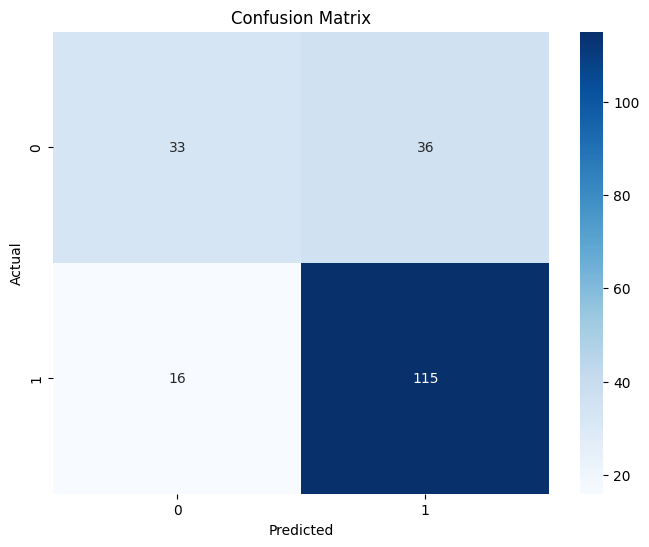

In [96]:
# Plot the confusion matrix using a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The model achieved an accuracy score of 0.74, which indicates that it correctly predicted 74% of the test samples. The confusion matrix shows the distribution of predictions, where the top-left cell represents the number of true negatives (33), the top-right cell represents false positives (36), the bottom-left cell represents false negatives (16), and the bottom-right cell represents true positives (115).

The F-beta score, with a beta value of 2, is a metric that combines precision and recall, giving more weight to recall. In this case, the F-beta score is 0.8518, indicating that the model performs reasonably well in terms of both precision and recall for the given beta value.

The model shows a promising performance with a relatively high accuracy score, a well-distributed confusion matrix, and a good F-beta score.

In [90]:
def plot_roc(X, y, estemator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

The function above is used to plot the Receiver Operating Characteristic (ROC) curve for a given classifier.

The function takes as input the features (X) and target variable (y), the estimator (classifier) to be evaluated, the number of splits for cross-validation (n_splits), and the number of points to plot the ROC curve (lns).

Within the function, we have a stratified K-fold cross-validation is performed using n_splits folds. The classifier (estemator) is trained and evaluated on each fold. The predicted probabilities of the positive class are obtained using predict_proba, and the false positive rate (fpr), true positive rate (tpr), and thresholds (t) are calculated using the roc_curve function.

The function iterates over each fold, plots the ROC curve for the fold, and calculates the area under the curve (AUC) for each fold. These values are stored in tprs and aucs, respectively.

After plotting the ROC curves for each fold, the mean ROC curve is computed by taking the average of the true positive rates (mean_tpr) across all folds. The mean AUC is also calculated based on the mean FPR and mean TPR. The mean ROC curve and its corresponding AUC are then plotted in gold color.

The function sets up the labels, including the legend, title, and axis labels, for the ROC plot. The legend is positioned at the top-right corner, and the title indicates that it is an ROC plot. The x-axis represents the false positive rate, and the y-axis represents the true positive rate.

Overall, this function allows for the visualization and evaluation of the classifier's performance using the ROC curve, which provides insights into the trade-off between the true positive rate and the false positive rate at various classification thresholds.

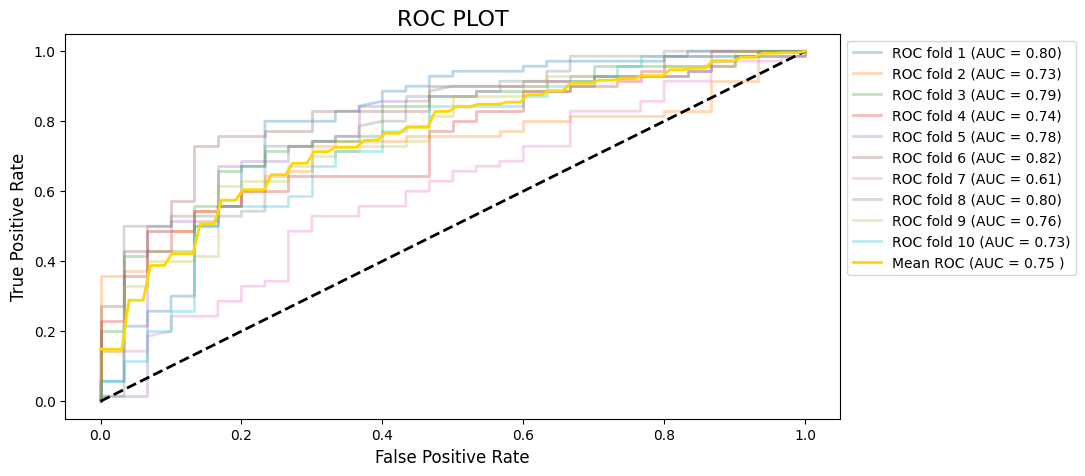

In [91]:
rf_model = RandomForestClassifier()
rf_model.set_params(**grid_search.best_params_)

plot_roc(x,y, rf_model, n_splits=10)

The reported AUC values for each fold range from 0.61 to 0.82. These values indicate the performance of the model in distinguishing between the positive and negative classes across different train-test splits. The mean AUC value of 0.75 suggests that, on average, the model has a moderate discriminatory power.

## Summary

Throughout the analysis, we explored a dataset containing information about credit applications. We started by examining the dataset's structure, variable types, and missing values. After that, we conducted exploratory data analysis to gain insights into the relationships and distributions of different variables.

In the EDA phase, we visualized various aspects of the data using different plots and techniques. We observed the distributions of variables such as age, credit amount, and duration using histograms and box plots. We also investigated relationships between variables, such as credit amount and duration, using scatter plots and correlation analysis.

Additionally, we explored categorical variables, including housing, job category, and risk. We examined their distributions, looked for differences between groups, and assessed potential relationships with other variables. Visualizations such as bar plots and box plots helped us gain a better understanding of the patterns and trends within the data.

We further applied clustering techniques to group similar instances together based on numerical variables. Affinity Propagation was utilized to identify clusters within the data, and we interpreted the results by examining the characteristics and stereotypes associated with each cluster.

Finally, we employed machine learning algorithms, such as Random Forest and GridSearchCV, to train models and make predictions. We assessed the performance of the models using metrics like accuracy, confusion matrix, and F-beta score. We also utilized ROC AUC curves to evaluate the models' discriminatory power.

In conclusion, the analysis provided valuable insights into the credit application dataset. We identified relationships and patterns within the data, explored the impact of different variables, and assessed the performance of predictive models. These findings can be utilized to better understand the factors influencing credit applications and to develop strategies for risk assessment and decision-making in credit-related scenarios.